In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
# local
from wrangle import acquire_zillow, clean_zillow, wrangle_zillow, train_val_test, xy_split, scale_data
from explore import dist_of_nums, plot_variable_pairs, plot_categorical_and_continuous_vars, evaluate_correlation
from model import eval_model, train_model, train_and_evaluate_model


# custom imports
import wrangle as w
import prepare as p
import explore as e

# AQUISITION PHASE OF DATA

In [2]:
### Query used to filter data from database,

# SELECT *

# SELECT bathroomcnt, bedroomcnt, calculatedbathnbr, calculatedfinishedsquarefeet, fips, fullbathcnt, garagecarcnt, 
# garagetotalsqft, heatingorsystemtypeid, latitude, longitude, lotsizesquarefeet, poolcnt, propertycountylandusecode, propertyzoningdesc, 
# rawcensustractandblock, regionidcity, regionidcounty, regionidneighborhood, regionidzip, roomcnt, unitcnt, yearbuilt, numberofstories,  
# taxvaluedollarcnt, assessmentyear, censustractandblock

# FROM properties_2017 AS p17
# LEFT JOIN predictions_2017 AS pr17 ON p17.id = pr17.id
# LEFT JOIN propertylandusetype AS plu ON p17.propertylandusetypeid = plu.propertylandusetypeid
# WHERE plu.propertylandusetypeid = 261 AND YEAR(pr17.transactiondate) = 2017; -- 'Single Family Residential' and transactions in 2017

In [3]:
# changed key id to for sql query above. 
# Parcel_id seems to be a more unique identifier versus the general id, the general id can be ambiguous so it's better to use parcel id to not have mismatched properties with identifier.

# went ahead and changed the query again to return wanted columns instead of generating 65 columns
# adjsted a third time to get columns with only a few null values

In [4]:
# Constants
filename = 'zillow_data.csv'

# Acquire data.
# ----------------------ACQUIRE FUNCTION---------------------------------
def acquire_zillow():

    if os.path.isfile(filename):
        
        return pd.read_csv(filename)
        
    else: 

        query = '''
        SELECT p17.parcelid, bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, fullbathcnt, latitude, longitude, lotsizesquarefeet,
        regionidcounty, regionidzip, roomcnt, yearbuilt, taxvaluedollarcnt, censustractandblock, fips
        FROM properties_2017 AS p17
        LEFT JOIN predictions_2017 AS pr17 ON p17.parcelid = pr17.parcelid
        LEFT JOIN propertylandusetype AS plu ON p17.propertylandusetypeid = plu.propertylandusetypeid
        WHERE plu.propertylandusetypeid = 261 AND YEAR(pr17.transactiondate) = 2017; -- 'Single Family Residential' and transactions in 2017
        '''

        url = get_connection('zillow')
                
        df = pd.read_sql(query, url)

        # # save to csv
        # df.to_csv(filename,index=False)

        return df 

In [5]:
# acquiring data
df = w.acquire_zillow()
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [6]:
# checking shape of data
df.shape

(51732, 17)

In [7]:
# checking info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51732 entries, 0 to 51731
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   parcel_id               51732 non-null  int64  
 1   bathrooms               51732 non-null  float64
 2   bedrooms                51732 non-null  int64  
 3   area                    51732 non-null  int64  
 4   full_bath_cnt           51732 non-null  int64  
 5   latitude                51732 non-null  float64
 6   longitude               51732 non-null  float64
 7   lot_area                51732 non-null  int64  
 8   region_id_county        51732 non-null  int64  
 9   regionidzip             51732 non-null  int64  
 10  room_cnt                51732 non-null  int64  
 11  year_built              51732 non-null  int64  
 12  home_value              51732 non-null  int64  
 13  census_tract_and_block  51732 non-null  float64
 14  fips                    51732 non-null

# PREP PHASE OF DATA

In [8]:
# created dup to see how many duplicated rows are in my data frame
dup = df.duplicated() == True
dup.sum()

0

In [9]:
dup = df.duplicated() == False
dup.sum()

51732

In [10]:
dup = df[df.duplicated() == True]
dup.shape

(0, 17)

In [11]:
# double checked for all features again for duplicates
all_duplicates = df[df.duplicated(keep='first')]
all_duplicates

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county


In [12]:
# wanted to see if the rows are actually in fact duplicated and I confirmed with a boolean mask to return rows with the same parcelid
# parcelid should be a unique identifier for these properties
dups = df[df['parcel_id'] == 11721753]
dups

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
664,11721753,2.0,3,1316,2,34033180.0,-118355396.0,5672,3101,95997,0,1923,205123,6.037220e+13,6037,California,Los Angeles County


In [13]:
# found a parcelid with more than 2 duplicates, realizing multiple with different dates as long features of one property stay in the dataframe should be fine
dups = df[df['parcel_id'] == 11991059]
dups

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county


In [14]:
# checked for all parcelid duplicates and I identified 241 rows
duplicate_parcelids = df[df.duplicated(subset=['parcel_id'], keep=False)]
duplicate_parcelids.shape

(0, 17)

In [15]:
52441 - 52320

121

In [16]:
# ~ is used to exclude the rows with duplicate 'parcelid' values from the DataFrame by inverting the boolean Series that identifies duplicates.
df = df[~df.duplicated(keep='first')]
df.shape

(51732, 17)

In [17]:
# double checked for all features again for duplicates
all_duplicates = df[df.duplicated(keep=False)]
all_duplicates

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county


In [18]:
# double checked by parcelid column again for duplicates
duplicate_parcelids = df[df.duplicated(subset=['parcel_id'], keep=False)]
duplicate_parcelids.shape

(0, 17)

In [19]:
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [20]:
# checked for all null values; i may be losing approximately 37788 columns in df
df.isna().sum()

parcel_id                 0
bathrooms                 0
bedrooms                  0
area                      0
full_bath_cnt             0
latitude                  0
longitude                 0
lot_area                  0
region_id_county          0
regionidzip               0
room_cnt                  0
year_built                0
home_value                0
census_tract_and_block    0
fips                      0
state                     0
county                    0
dtype: int64

I may impute some values for features with less than 500 null values, and drop anything over that.

In [21]:
# df[df['unitcnt'] == 1.0] # may impute 1.0 for unitcnt

In [22]:
# dropping all nulls erases all rows; can't do that, i have to figure out another way to prep data
df2 = df.dropna()
df2

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51727,12412492,2.0,4,1633,2,33870815.0,-118070858.0,4630,3101,96204,0,1962,346534,6.037555e+13,6037,California,Los Angeles County
51728,11000655,2.0,2,1286,2,34245368.0,-118282383.0,47405,3101,96284,0,1940,354621,6.037101e+13,6037,California,Los Angeles County
51729,17239384,2.0,4,1612,2,34300140.0,-118706327.0,12105,2061,97116,7,1964,67205,6.111008e+13,6111,California,Ventura County
51730,12773139,1.0,3,1032,1,34040895.0,-118038169.0,5074,3101,96480,0,1954,49546,6.037434e+13,6037,California,Los Angeles County


In [23]:
# dropped columns with large null values
# df = df.drop(columns=['garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'poolcnt', 'propertyzoningdesc', 'regionidcity', 'regionidneighborhood', 'unitcnt', 'numberofstories']) 

In [24]:
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [25]:
# checked shape
df.shape

(51732, 17)

In [26]:
# checked to see my resulting df info, there are less large null counts  so now i can probably dropna() and not lose my entire data.
df.isna().sum()

parcel_id                 0
bathrooms                 0
bedrooms                  0
area                      0
full_bath_cnt             0
latitude                  0
longitude                 0
lot_area                  0
region_id_county          0
regionidzip               0
room_cnt                  0
year_built                0
home_value                0
census_tract_and_block    0
fips                      0
state                     0
county                    0
dtype: int64

In [27]:
# dropping all columns of current df
df = df.dropna()
df.shape

(51732, 17)

In [28]:
# checking for null values again
df.isna().sum()

parcel_id                 0
bathrooms                 0
bedrooms                  0
area                      0
full_bath_cnt             0
latitude                  0
longitude                 0
lot_area                  0
region_id_county          0
regionidzip               0
room_cnt                  0
year_built                0
home_value                0
census_tract_and_block    0
fips                      0
state                     0
county                    0
dtype: int64

In [29]:
# checking shape, looks like my dataframe was reduced to approximately 600 rows that contained null values
df.shape

(51732, 17)

In [30]:
# make sure the math is mathing
52320 - 51732

588

In [31]:
# looking over the column names see if I can change these to be more pythonic
df.dtypes

parcel_id                   int64
bathrooms                 float64
bedrooms                    int64
area                        int64
full_bath_cnt               int64
latitude                  float64
longitude                 float64
lot_area                    int64
region_id_county            int64
regionidzip                 int64
room_cnt                    int64
year_built                  int64
home_value                  int64
census_tract_and_block    float64
fips                        int64
state                      object
county                     object
dtype: object

In [32]:
# renamed appropriately
df = df.rename(columns={'bedroomcnt': 'bedrooms', 'bathroomcnt': 'bathrooms', 
                            'calculatedfinishedsquarefeet': 'area', 'taxvaluedollarcnt': 'home_value', 
                            'yearbuilt': 'year_built', 'fullbathcnt' : 'full_bath_cnt', 'lotsizesquarefeet' : 'lot_area', 'regionidcounty' : 'region_id_county',
                            'roomcnt' : 'room_cnt', 'censustractandblock' : 'census_tract_and_block'})

In [33]:
# looking at dataframe to ensure changes were made to columns
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [34]:
# can i change the dtypes from flot to int for most of these?
df.dtypes

parcel_id                   int64
bathrooms                 float64
bedrooms                    int64
area                        int64
full_bath_cnt               int64
latitude                  float64
longitude                 float64
lot_area                    int64
region_id_county            int64
regionidzip                 int64
room_cnt                    int64
year_built                  int64
home_value                  int64
census_tract_and_block    float64
fips                        int64
state                      object
county                     object
dtype: object

In [35]:
# used list of columns to change datatyoes from float to int.
int_columns = ['fips', 'year_built', 'home_value', 'area', 'bedrooms', 'full_bath_cnt', 'room_cnt', 'region_id_county', 'regionidzip', 'lot_area']
df[int_columns] = df[int_columns].astype(int)

In [36]:
# dtypes are now appropriately set
df.dtypes

parcel_id                   int64
bathrooms                 float64
bedrooms                    int64
area                        int64
full_bath_cnt               int64
latitude                  float64
longitude                 float64
lot_area                    int64
region_id_county            int64
regionidzip                 int64
room_cnt                    int64
year_built                  int64
home_value                  int64
census_tract_and_block    float64
fips                        int64
state                      object
county                     object
dtype: object

In [37]:
# looking for additional prep steps
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [38]:
# Mapped state names to fips code

fips_to_state = {
    6037: 'California',
    6059: 'California',
    6111: 'California',
    # Add more mappings for other states as needed
    }

# Mapped county names to fips code
fips_to_county = {
    6037: 'Los Angeles County',
    6059: 'Orange County',
    6111: 'Ventura County',
    # Add more mappings for other counties as needed
    }

# Use the map method to create new 'county' and 'state' columns based on 'fips' column
df['state'] = df['fips'].map(fips_to_state)
df['county'] = df['fips'].map(fips_to_county)

In [39]:
# checking to see if the columns are added to the dataframe
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [40]:
# defined function to clean the zillow data
def clean_zillow(df):
    """
    Cleans the Zillow data.
    
    Args:
    - df (DataFrame): Acquired Raw Zillow data.
    """

    # Drop rows with duplicates
    df = df[~df.duplicated(keep='first')]
    
    # Drop rows with missing/null values in any column
    df = df.dropna()

    # Rename columns
    df = df.rename(columns={'parcelid' : 'parcel_id', 'bedroomcnt': 'bedrooms',
                            'bathroomcnt':'bathrooms','calculatedfinishedsquarefeet': 'area',
                            'taxvaluedollarcnt': 'home_value','yearbuilt': 'year_built', 
                            'fullbathcnt' : 'full_bath_cnt','lotsizesquarefeet' : 'lot_area', 
                            'regionidcounty' : 'region_id_county', 'roomcnt' : 'room_cnt', 
                            'censustractandblock' : 'census_tract_and_block'})

    # Convert selected columns to integer type
    int_columns = ['fips', 'year_built', 'home_value', 'area', 'bedrooms', 'full_bath_cnt', 'room_cnt',
                   'region_id_county', 'regionidzip', 'lot_area']
    df[int_columns] = df[int_columns].astype(int)

    # Mapped state to fips code
    fips_to_state = {
        6037: 'California',
        6059: 'California',
        6111: 'California',
        # you may add more mappings for other states as needed
        }

    # Mapped county names to fips code
    fips_to_county = {
        6037: 'Los Angeles County',
        6059: 'Orange County',
        6111: 'Ventura County',
        # you may more mappings for other counties as needed
        }
    
    # Use the map method to create new 'county' and 'state' columns based on 'fips' column
    df['state'] = df['fips'].map(fips_to_state)
    df['county'] = df['fips'].map(fips_to_county)
    
    return df

In [41]:
df = w.clean_zillow(df)
df.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
0,14297519,3.5,4,3100,3,33634931.0,-117869207.0,4506,1286,96978,0,1998,1023282,6.059063e+13,6059,California,Orange County
1,17052889,1.0,2,1465,1,34449266.0,-119281531.0,12647,2061,97099,5,1967,464000,6.111001e+13,6111,California,Ventura County
2,14186244,2.0,3,1243,2,33886168.0,-117823170.0,8432,1286,97078,6,1962,564778,6.059022e+13,6059,California,Orange County
3,12177905,3.0,4,2376,3,34245180.0,-118240722.0,13038,3101,96330,0,1970,145143,6.037300e+13,6037,California,Los Angeles County
4,12095076,3.0,4,2962,3,34145202.0,-118179824.0,63000,3101,96293,0,1950,773303,6.037461e+13,6037,California,Los Angeles County


In [42]:
df.shape # checked

(51732, 17)

In [43]:
# dtypes includes objects, but they can be dropped for analysis of numerical features for this regression project.
df.dtypes

parcel_id                   int64
bathrooms                 float64
bedrooms                    int64
area                        int64
full_bath_cnt               int64
latitude                  float64
longitude                 float64
lot_area                    int64
region_id_county            int64
regionidzip                 int64
room_cnt                    int64
year_built                  int64
home_value                  int64
census_tract_and_block    float64
fips                        int64
state                      object
county                     object
dtype: object

### Now that i have taken care of all extraneous discrepancies within data i will now test my scale and split functions from the wrangle module

In [44]:
# data split worked!
train, val, test = w.train_val_test(df)
train.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,home_value,census_tract_and_block,fips,state,county
39762,12115385,2.0,3,1218,2,34164673.0,-118126949.0,9251,3101,96292,0,1921,432527,6.037462e+13,6037,California,Los Angeles County
48844,12825439,2.0,3,1662,2,33931418.0,-118001601.0,6455,3101,96172,0,1954,169135,6.037504e+13,6037,California,Los Angeles County
24439,12668213,1.0,3,1580,1,33821835.0,-118387104.0,7509,3101,96123,0,1948,163387,6.037621e+13,6037,California,Los Angeles County
48581,12266229,1.0,3,1079,1,33906624.0,-118240829.0,6249,3101,96092,0,1954,163308,6.037541e+13,6037,California,Los Angeles County
5570,14379497,3.0,4,1986,3,33611735.0,-117688925.0,7560,1286,96995,8,1968,461551,6.059032e+13,6059,California,Orange County


In [45]:
# xysplit of data is operational
X_train, y_train = w.xy_split(train, 'home_value')
X_train.head()

,parcel_id,bathrooms,bedrooms,area,full_bath_cnt,latitude,longitude,lot_area,region_id_county,regionidzip,room_cnt,year_built,census_tract_and_block,fips,state,county
39762,12115385,2.0,3,1218,2,34164673.0,-118126949.0,9251,3101,96292,0,1921,6.037462e+13,6037,California,Los Angeles County
48844,12825439,2.0,3,1662,2,33931418.0,-118001601.0,6455,3101,96172,0,1954,6.037504e+13,6037,California,Los Angeles County
24439,12668213,1.0,3,1580,1,33821835.0,-118387104.0,7509,3101,96123,0,1948,6.037621e+13,6037,California,Los Angeles County
48581,12266229,1.0,3,1079,1,33906624.0,-118240829.0,6249,3101,96092,0,1954,6.037541e+13,6037,California,Los Angeles County
5570,14379497,3.0,4,1986,3,33611735.0,-117688925.0,7560,1286,96995,8,1968,6.059032e+13,6059,California,Orange County


# EXPLORE PHASE OF DATA

In [46]:
df = w.wrangle_zillow()
train, val, test = p.train_val_test(df)
train.shape, val.shape, test.shape

((36212, 17), (7760, 17), (7760, 17))

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36212 entries, 39762 to 15795
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   parcel_id               36212 non-null  int64  
 1   bathrooms               36212 non-null  float64
 2   bedrooms                36212 non-null  int64  
 3   area                    36212 non-null  int64  
 4   full_bath_cnt           36212 non-null  int64  
 5   latitude                36212 non-null  float64
 6   longitude               36212 non-null  float64
 7   lot_area                36212 non-null  int64  
 8   region_id_county        36212 non-null  int64  
 9   regionidzip             36212 non-null  int64  
 10  room_cnt                36212 non-null  int64  
 11  year_built              36212 non-null  int64  
 12  home_value              36212 non-null  int64  
 13  census_tract_and_block  36212 non-null  float64
 14  fips                    36212 non-

In [48]:
train = train.sample(100)

In [49]:
# plot_variable_pairs(df)

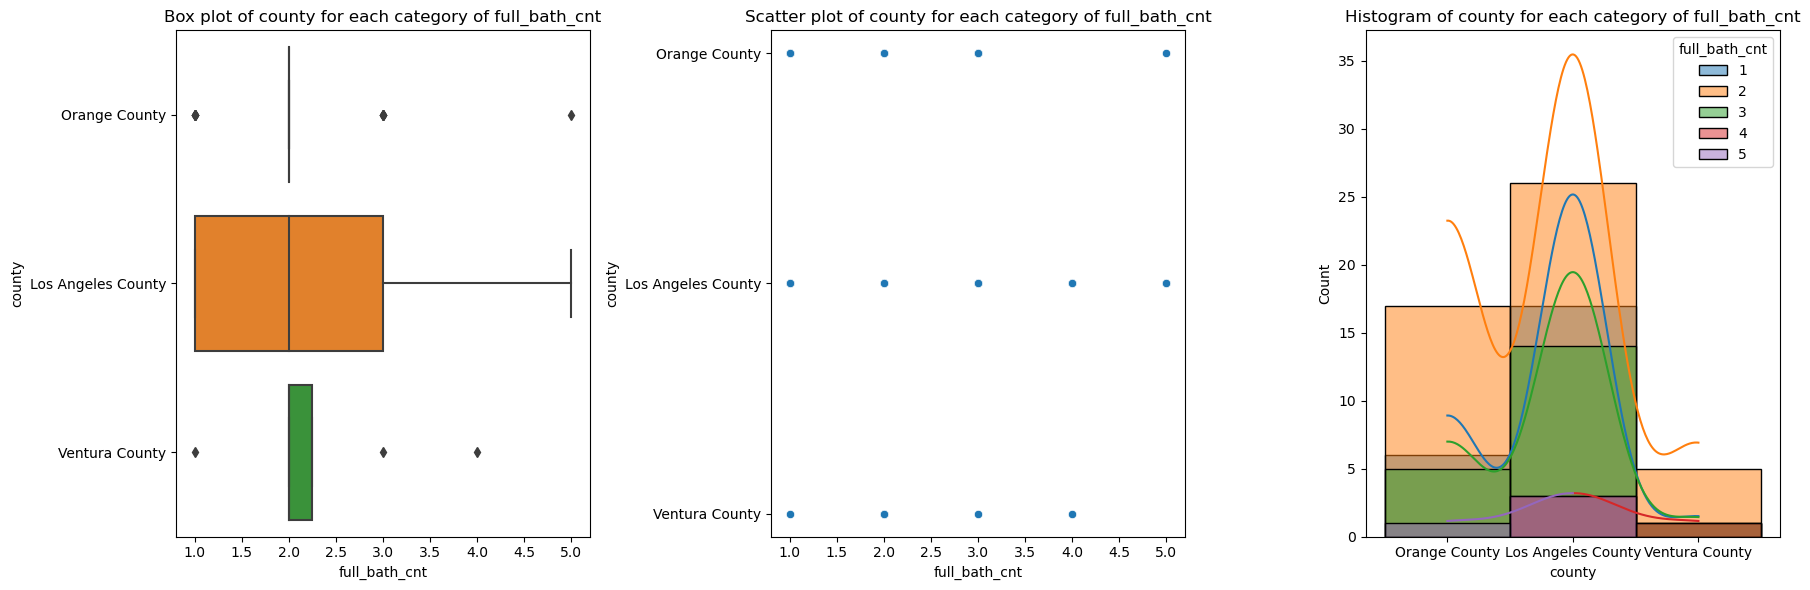

In [50]:
plot_categorical_and_continuous_vars(train, 'county', 'full_bath_cnt', n=(1, 1.5, 2, 2.5, 3, 3.5, 4, 20))

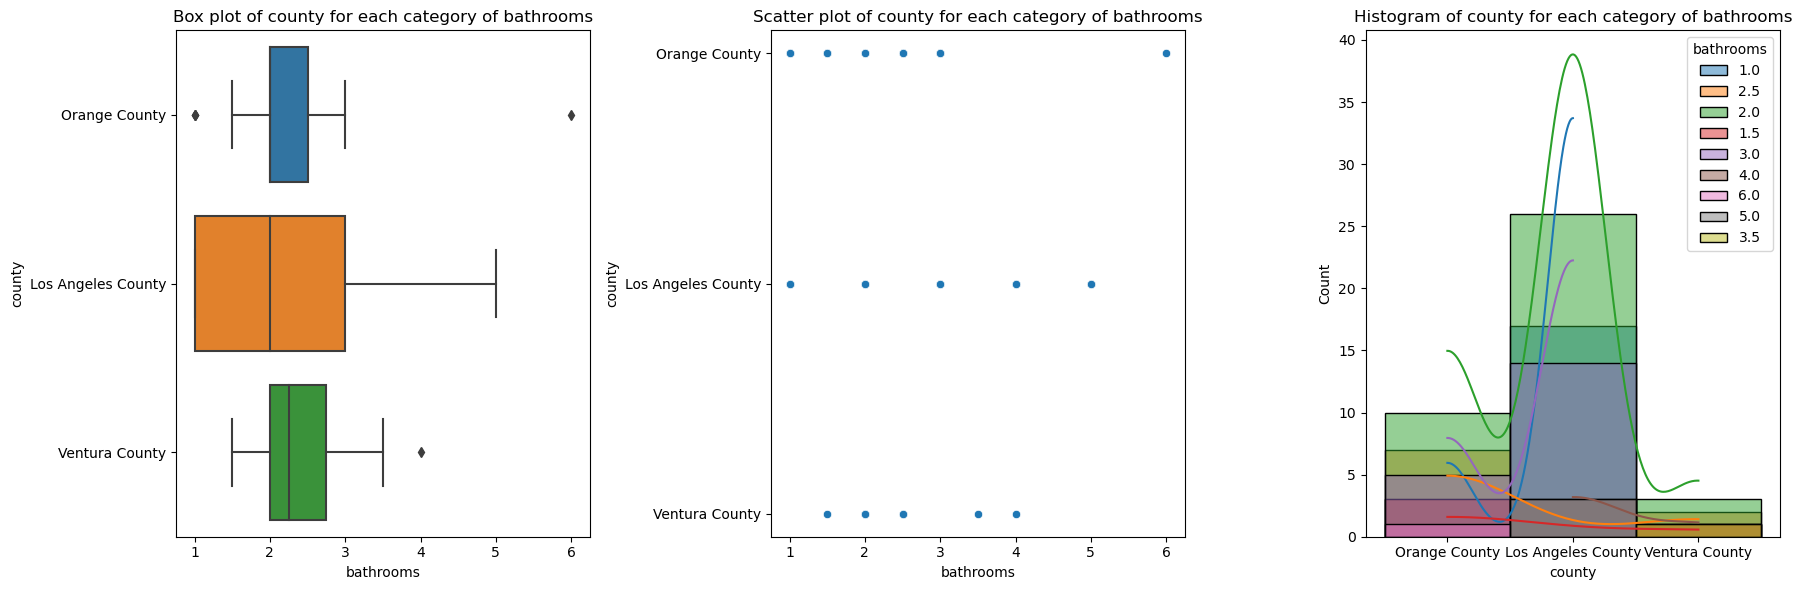

In [51]:
plot_categorical_and_continuous_vars(train, 'county', 'bathrooms', n=(1, 1.5, 2, 2.5, 3, 3.5, 4, 20))

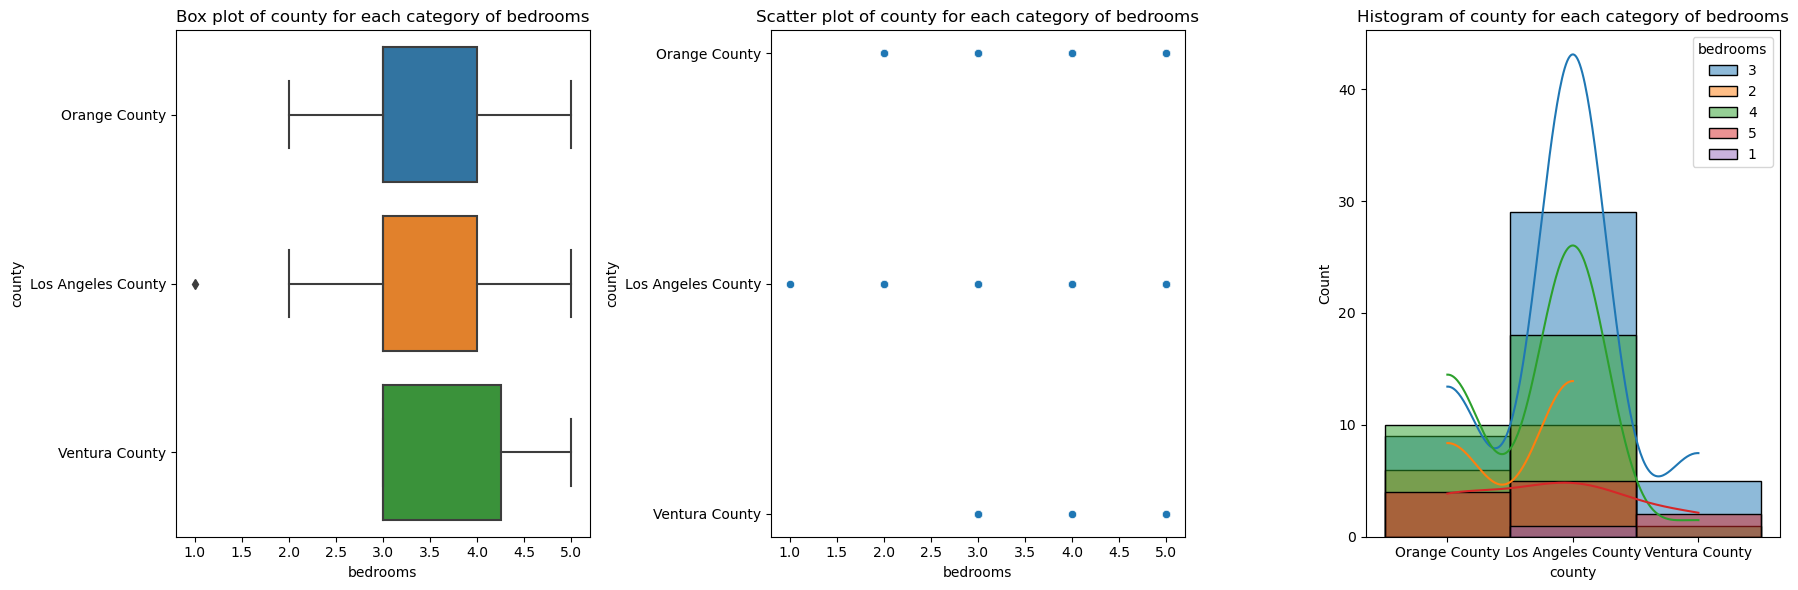

In [52]:
plot_categorical_and_continuous_vars(train, 'county', 'bedrooms', n=(0, 2.0, 4.0, 6.0, 20.0))

/Users/marc_aradillas/codeup-data-science/zillow_project/explore.py:92: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


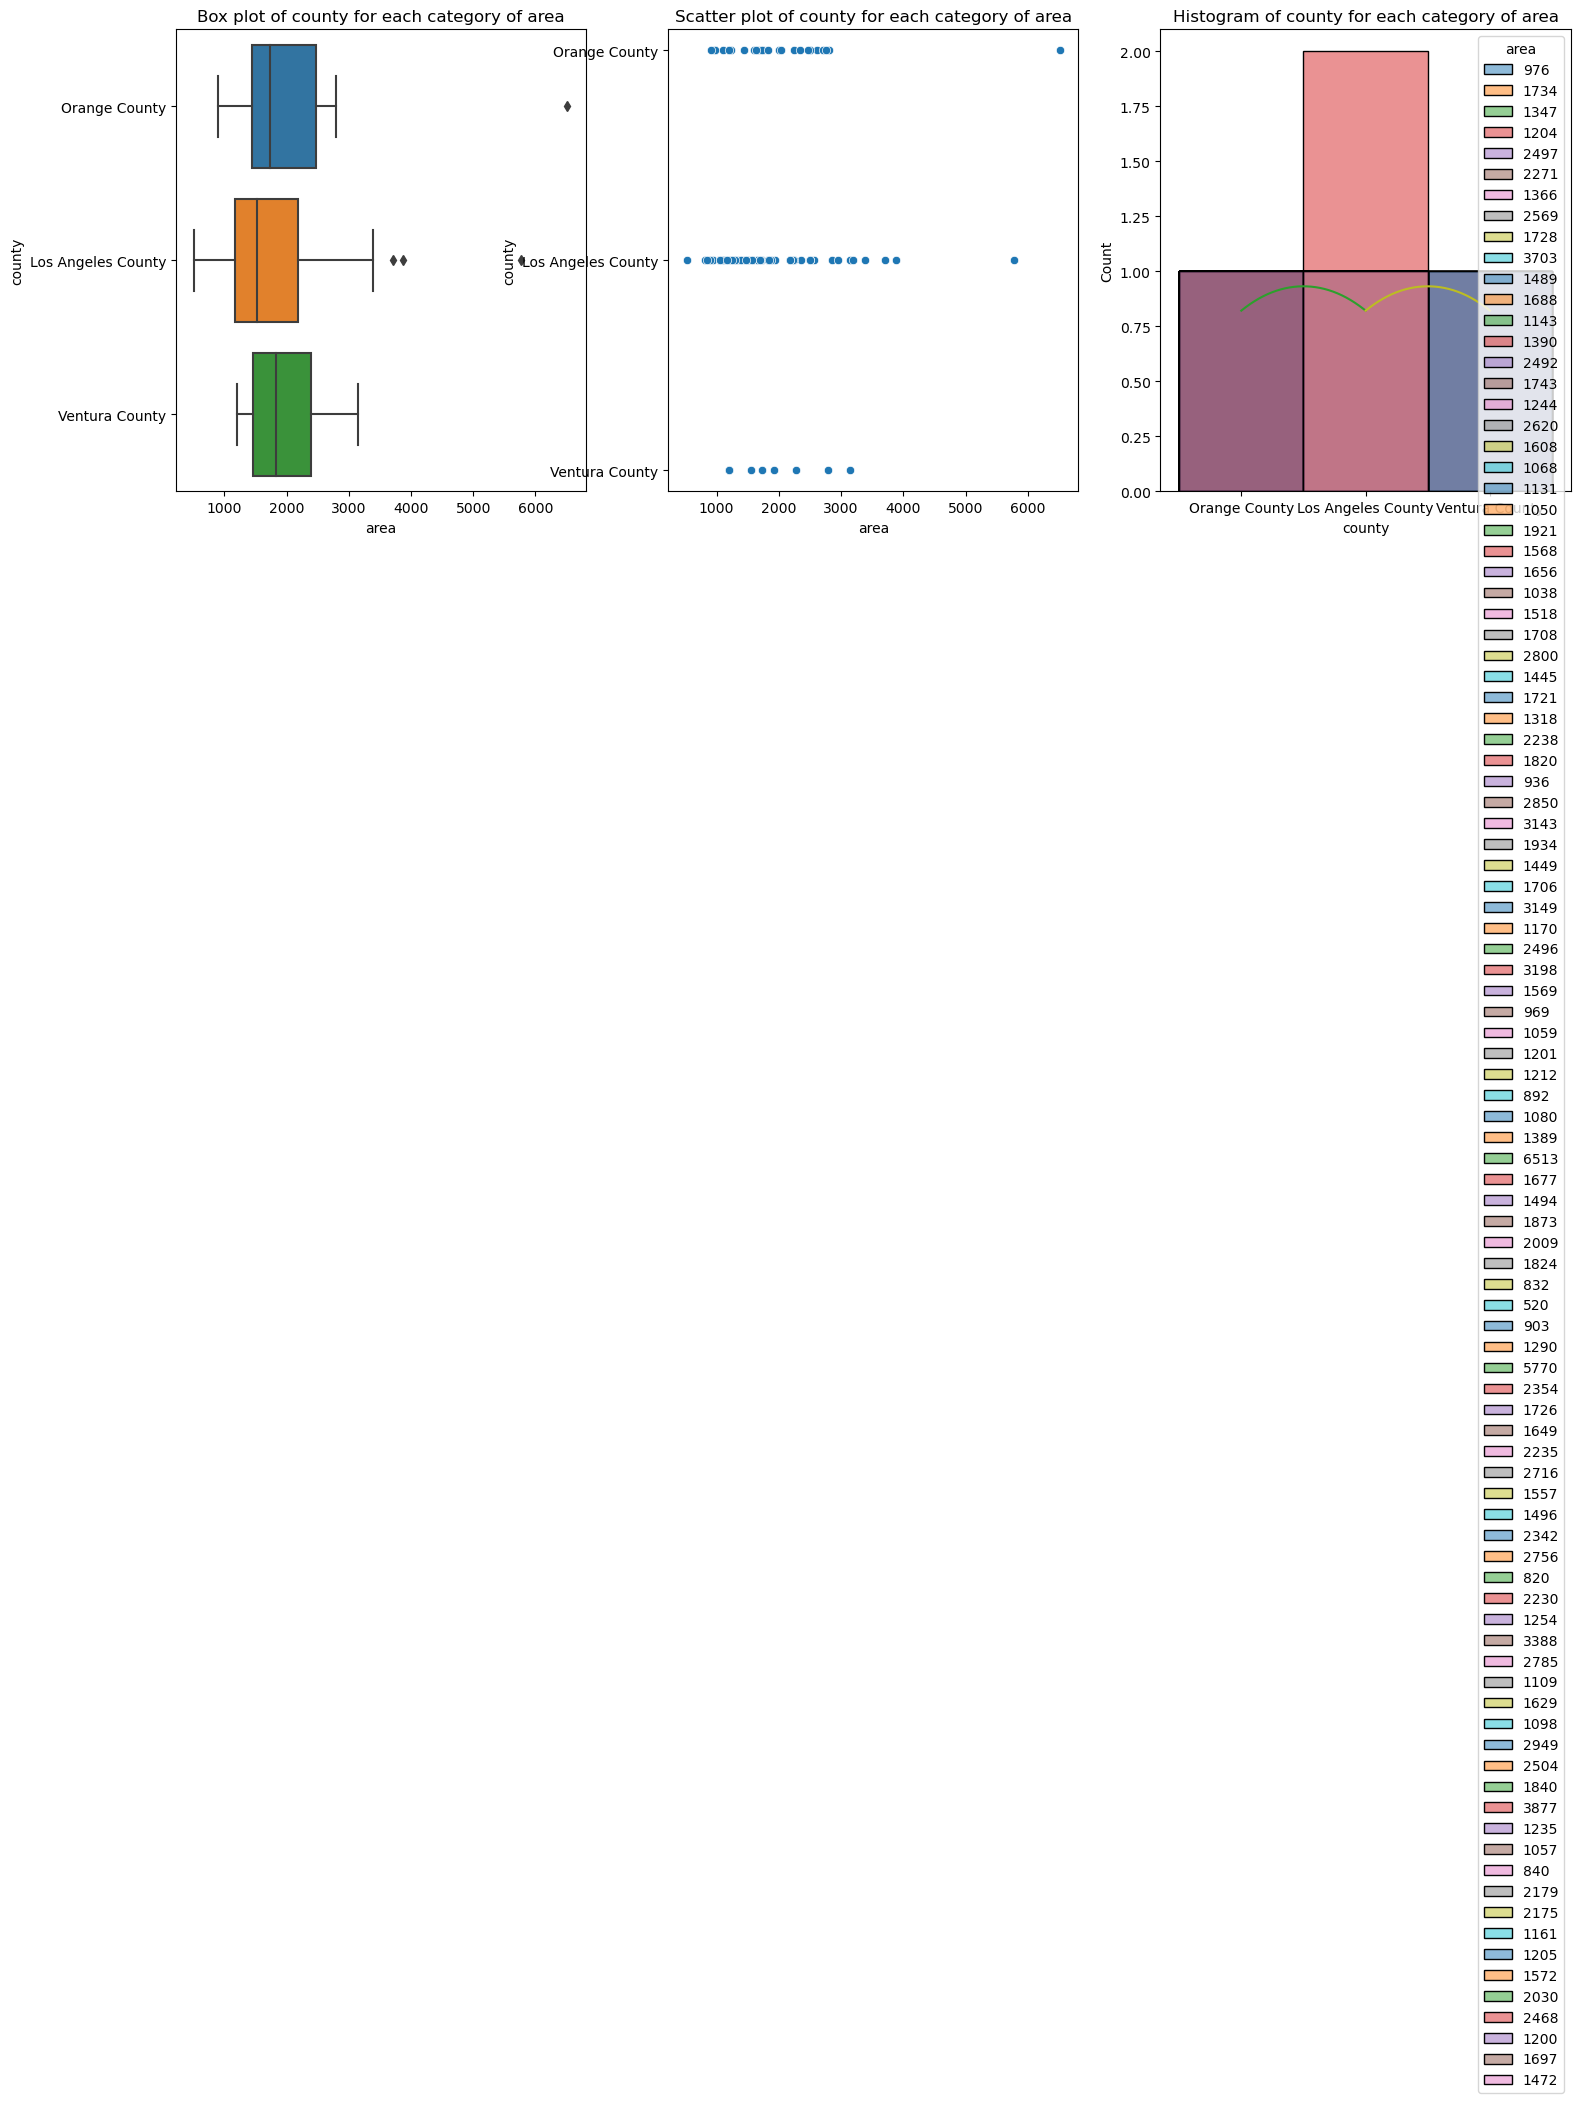

In [53]:
plot_categorical_and_continuous_vars(train, 'county', 'area', n=(675, 1350, 2700, 4000, 10000))

/Users/marc_aradillas/codeup-data-science/zillow_project/explore.py:92: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


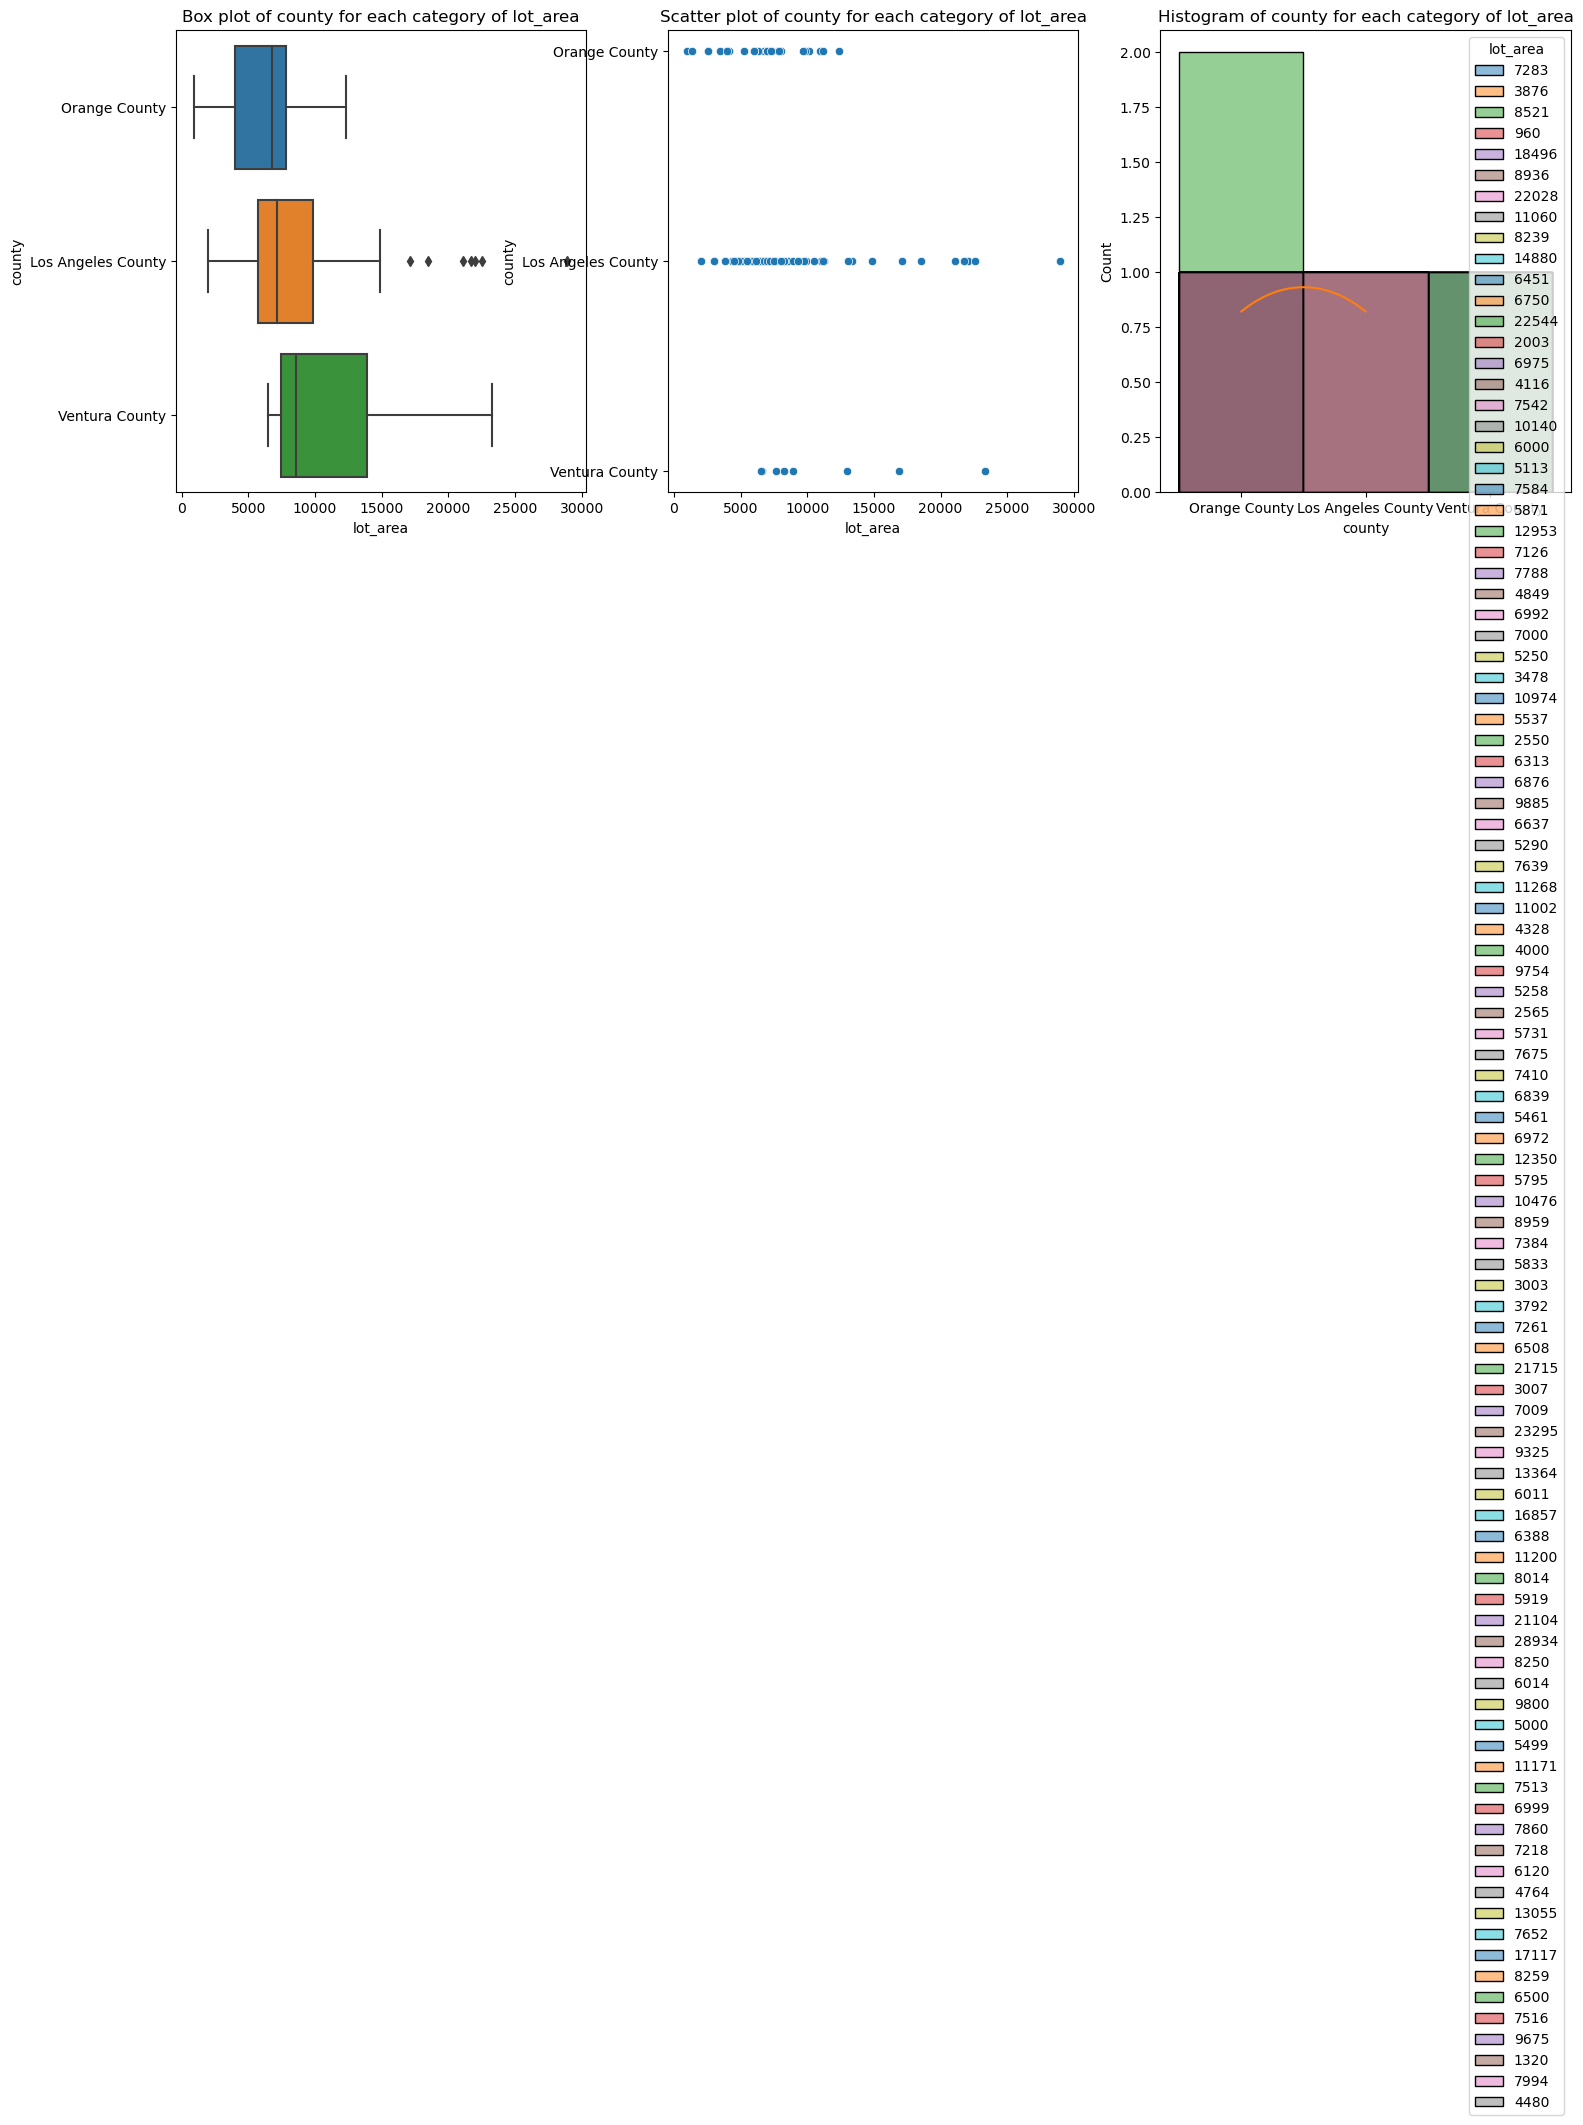

In [60]:
plot_categorical_and_continuous_vars(train, 'county', 'lot_area', n=(0, 675, 1350, 2700, 4000, 10000, 3000))

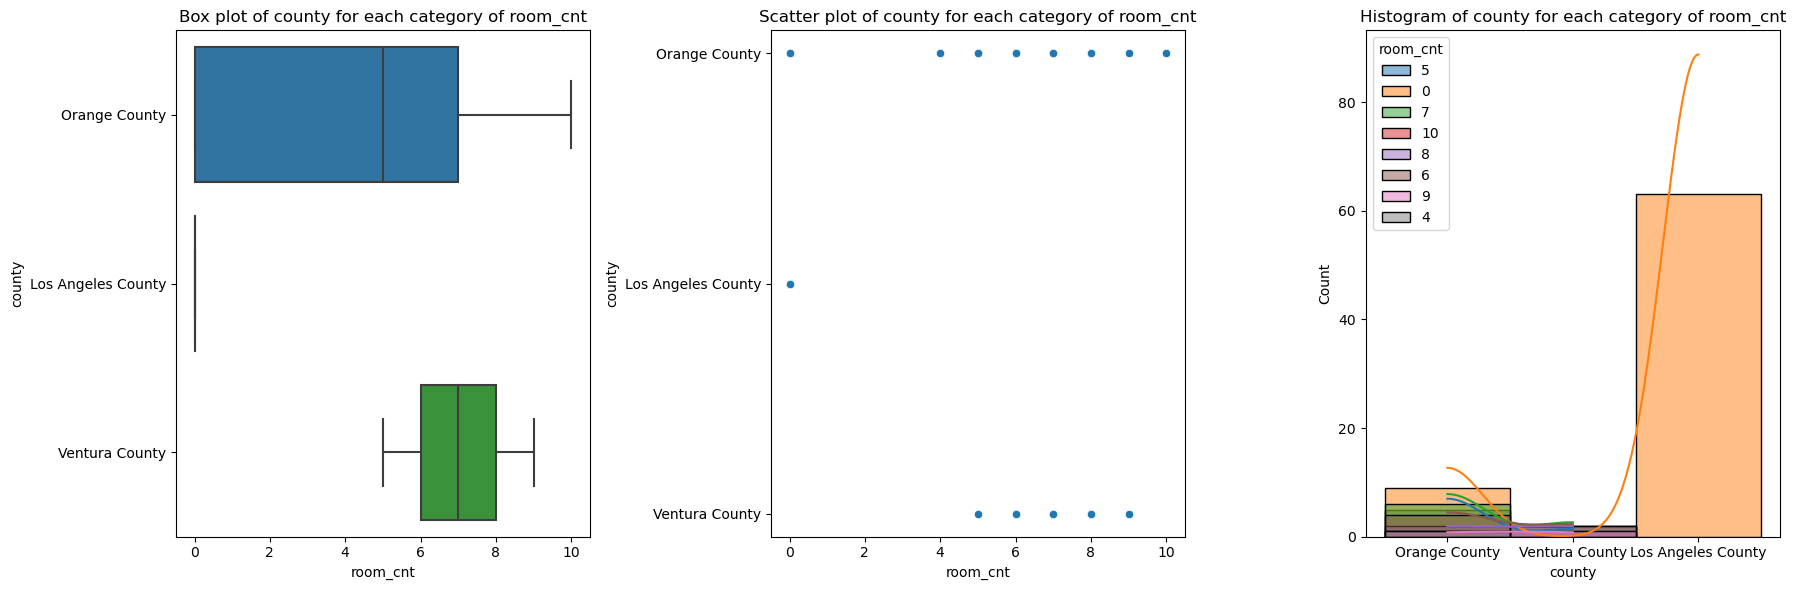

In [61]:
plot_categorical_and_continuous_vars(train, 'county', 'room_cnt', n=None)

/Users/marc_aradillas/codeup-data-science/zillow_project/explore.py:92: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


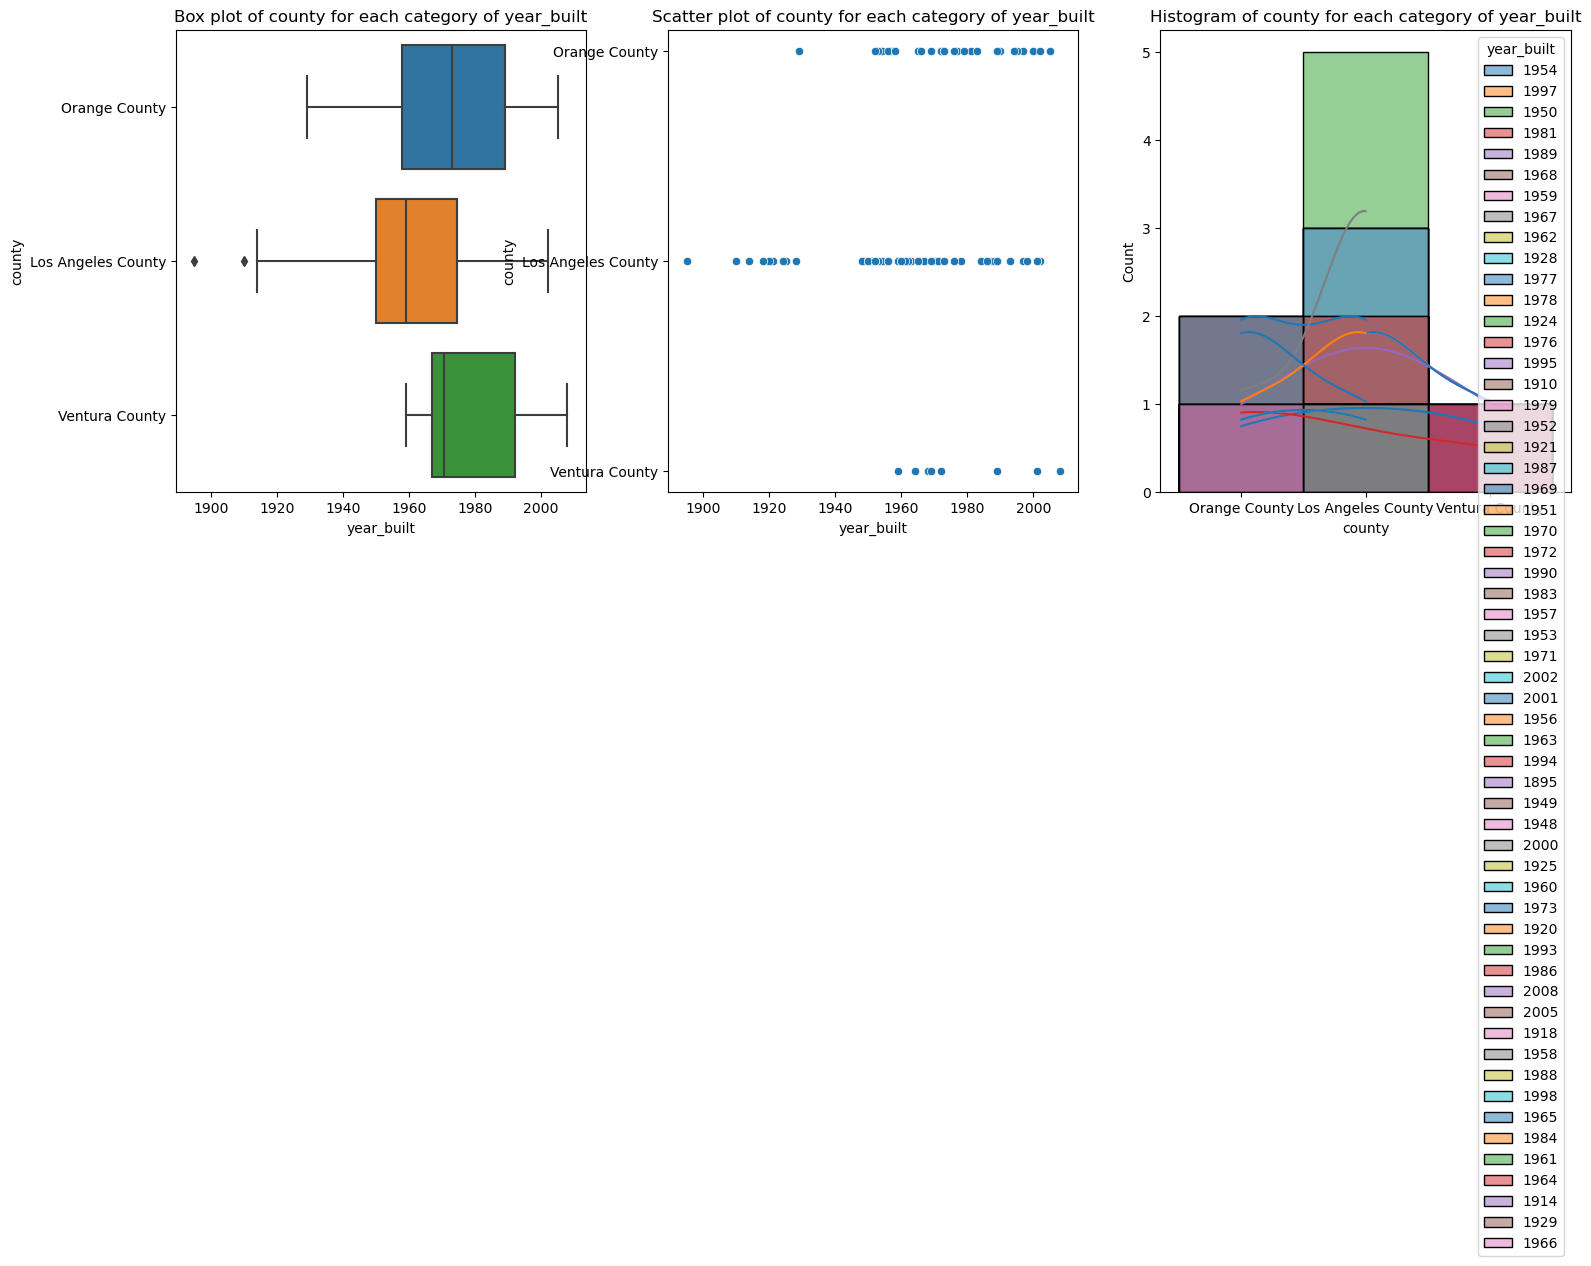

In [63]:
plot_categorical_and_continuous_vars(train, 'county', 'year_built', n=10)

/Users/marc_aradillas/codeup-data-science/zillow_project/explore.py:92: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


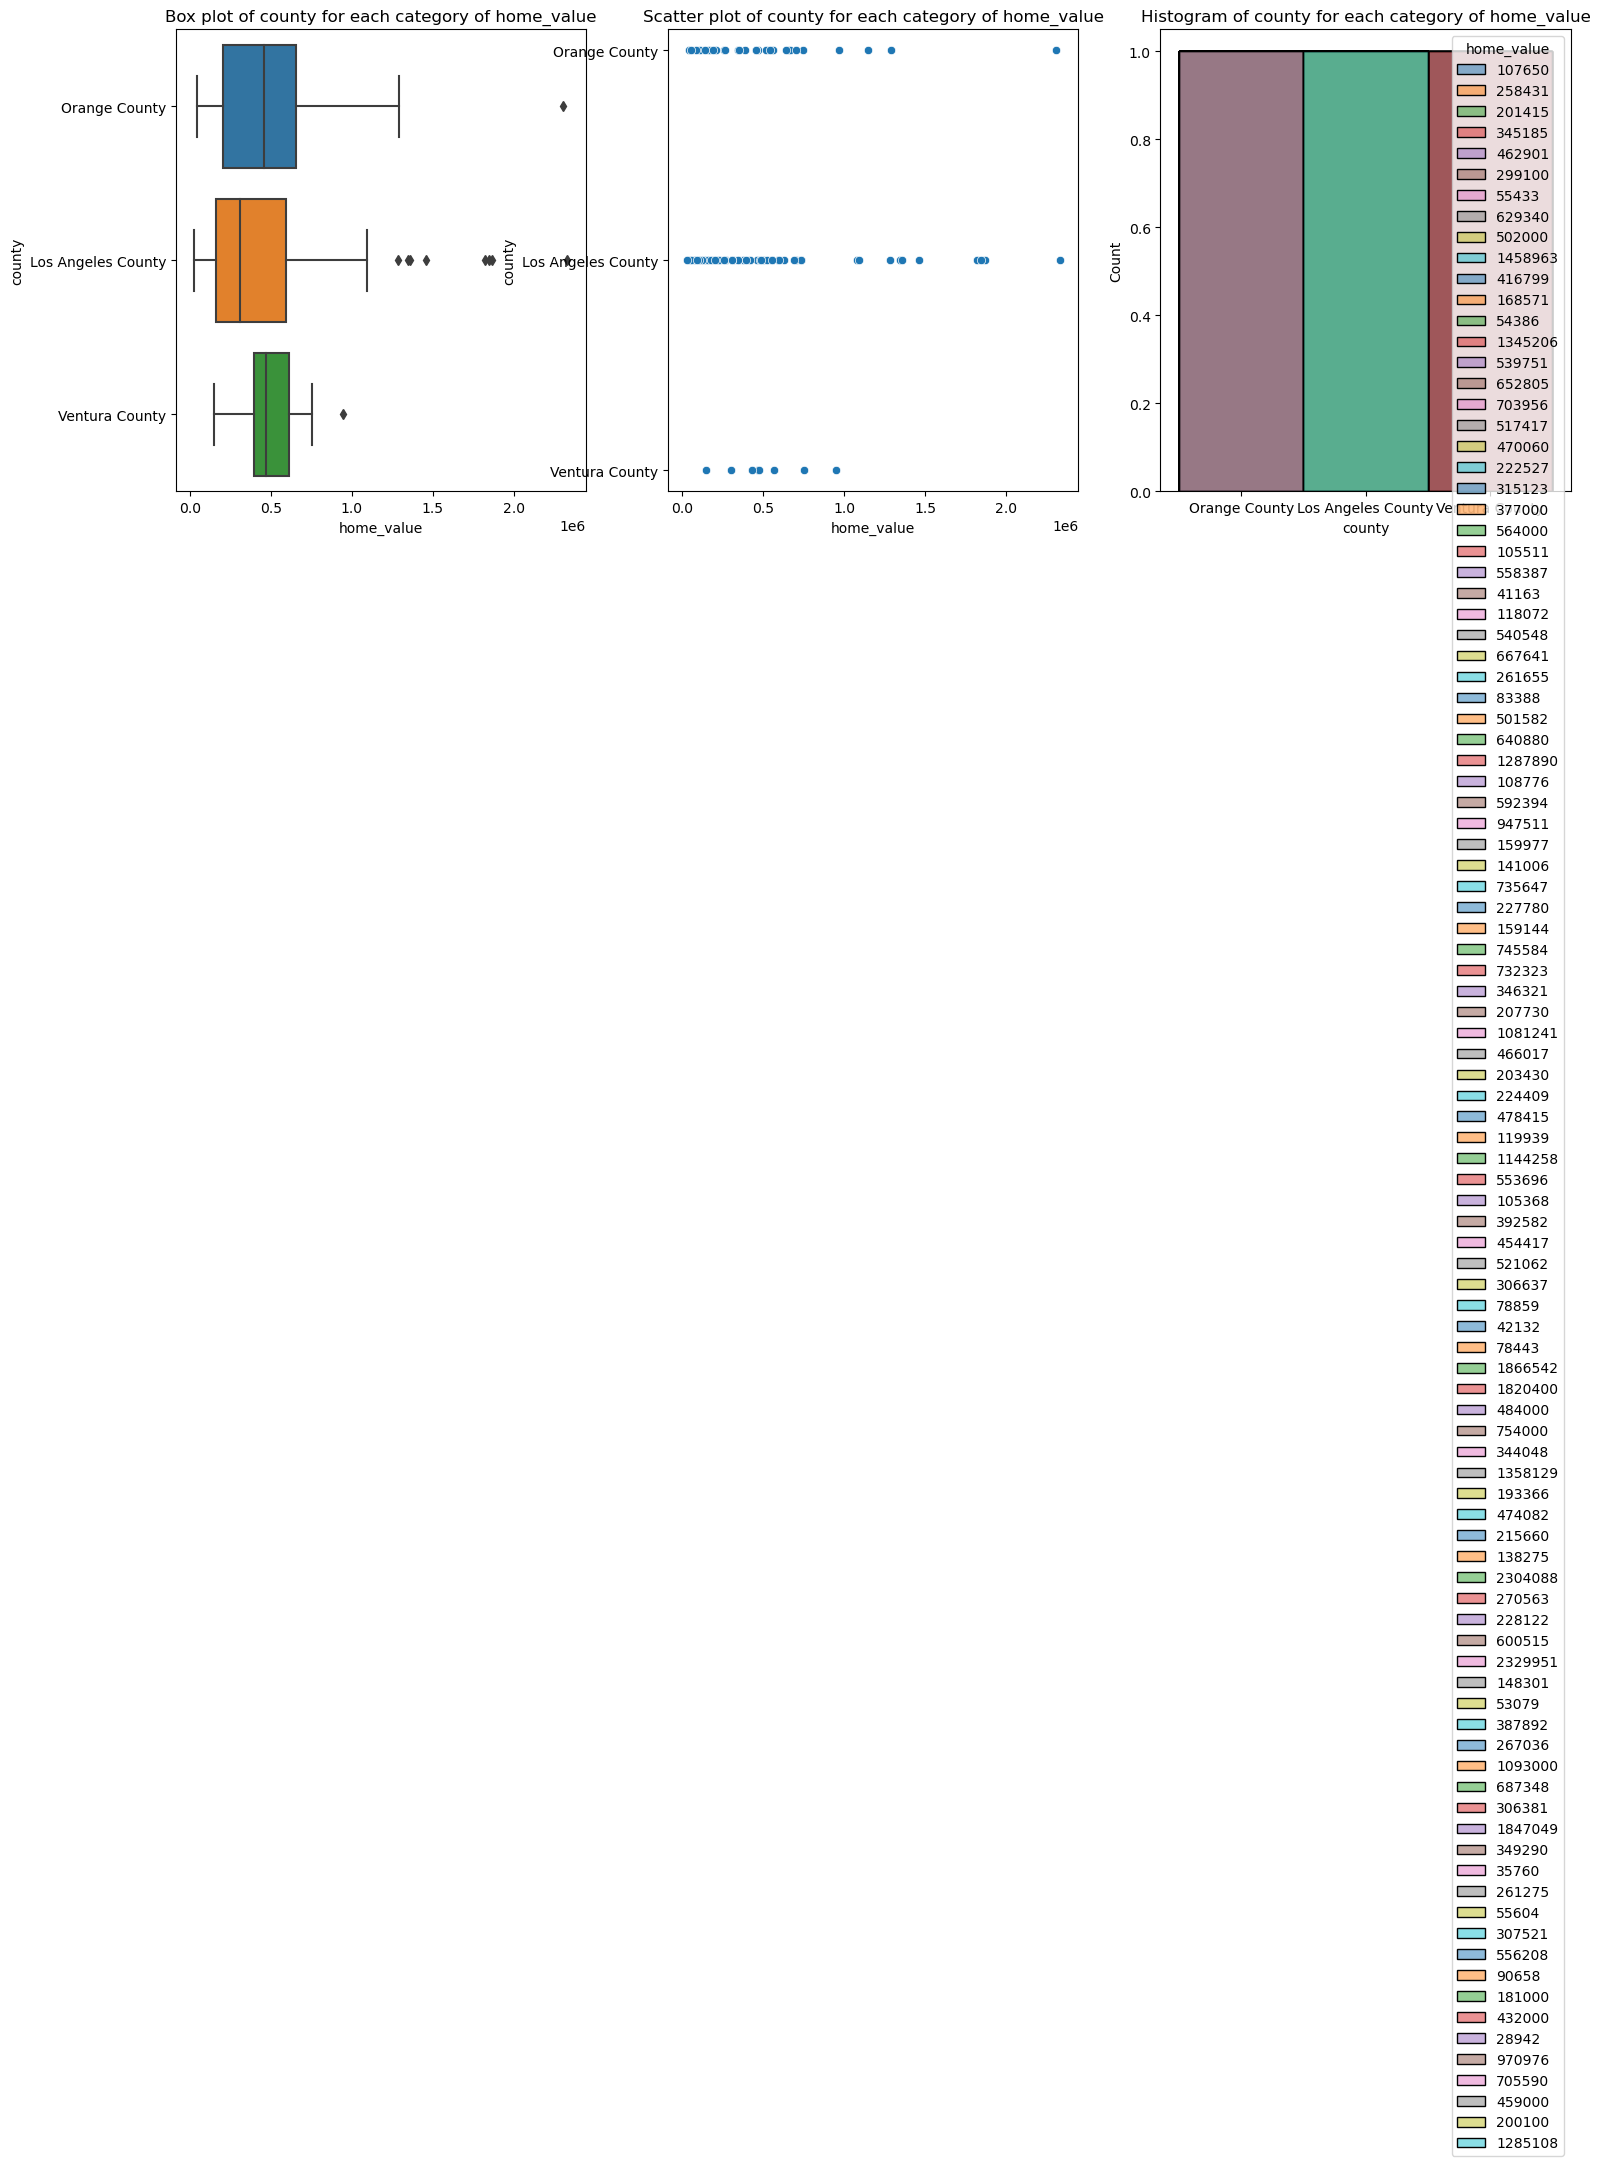

In [64]:
plot_categorical_and_continuous_vars(train, 'county', 'home_value', n=None)

/Users/marc_aradillas/codeup-data-science/zillow_project/explore.py:92: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


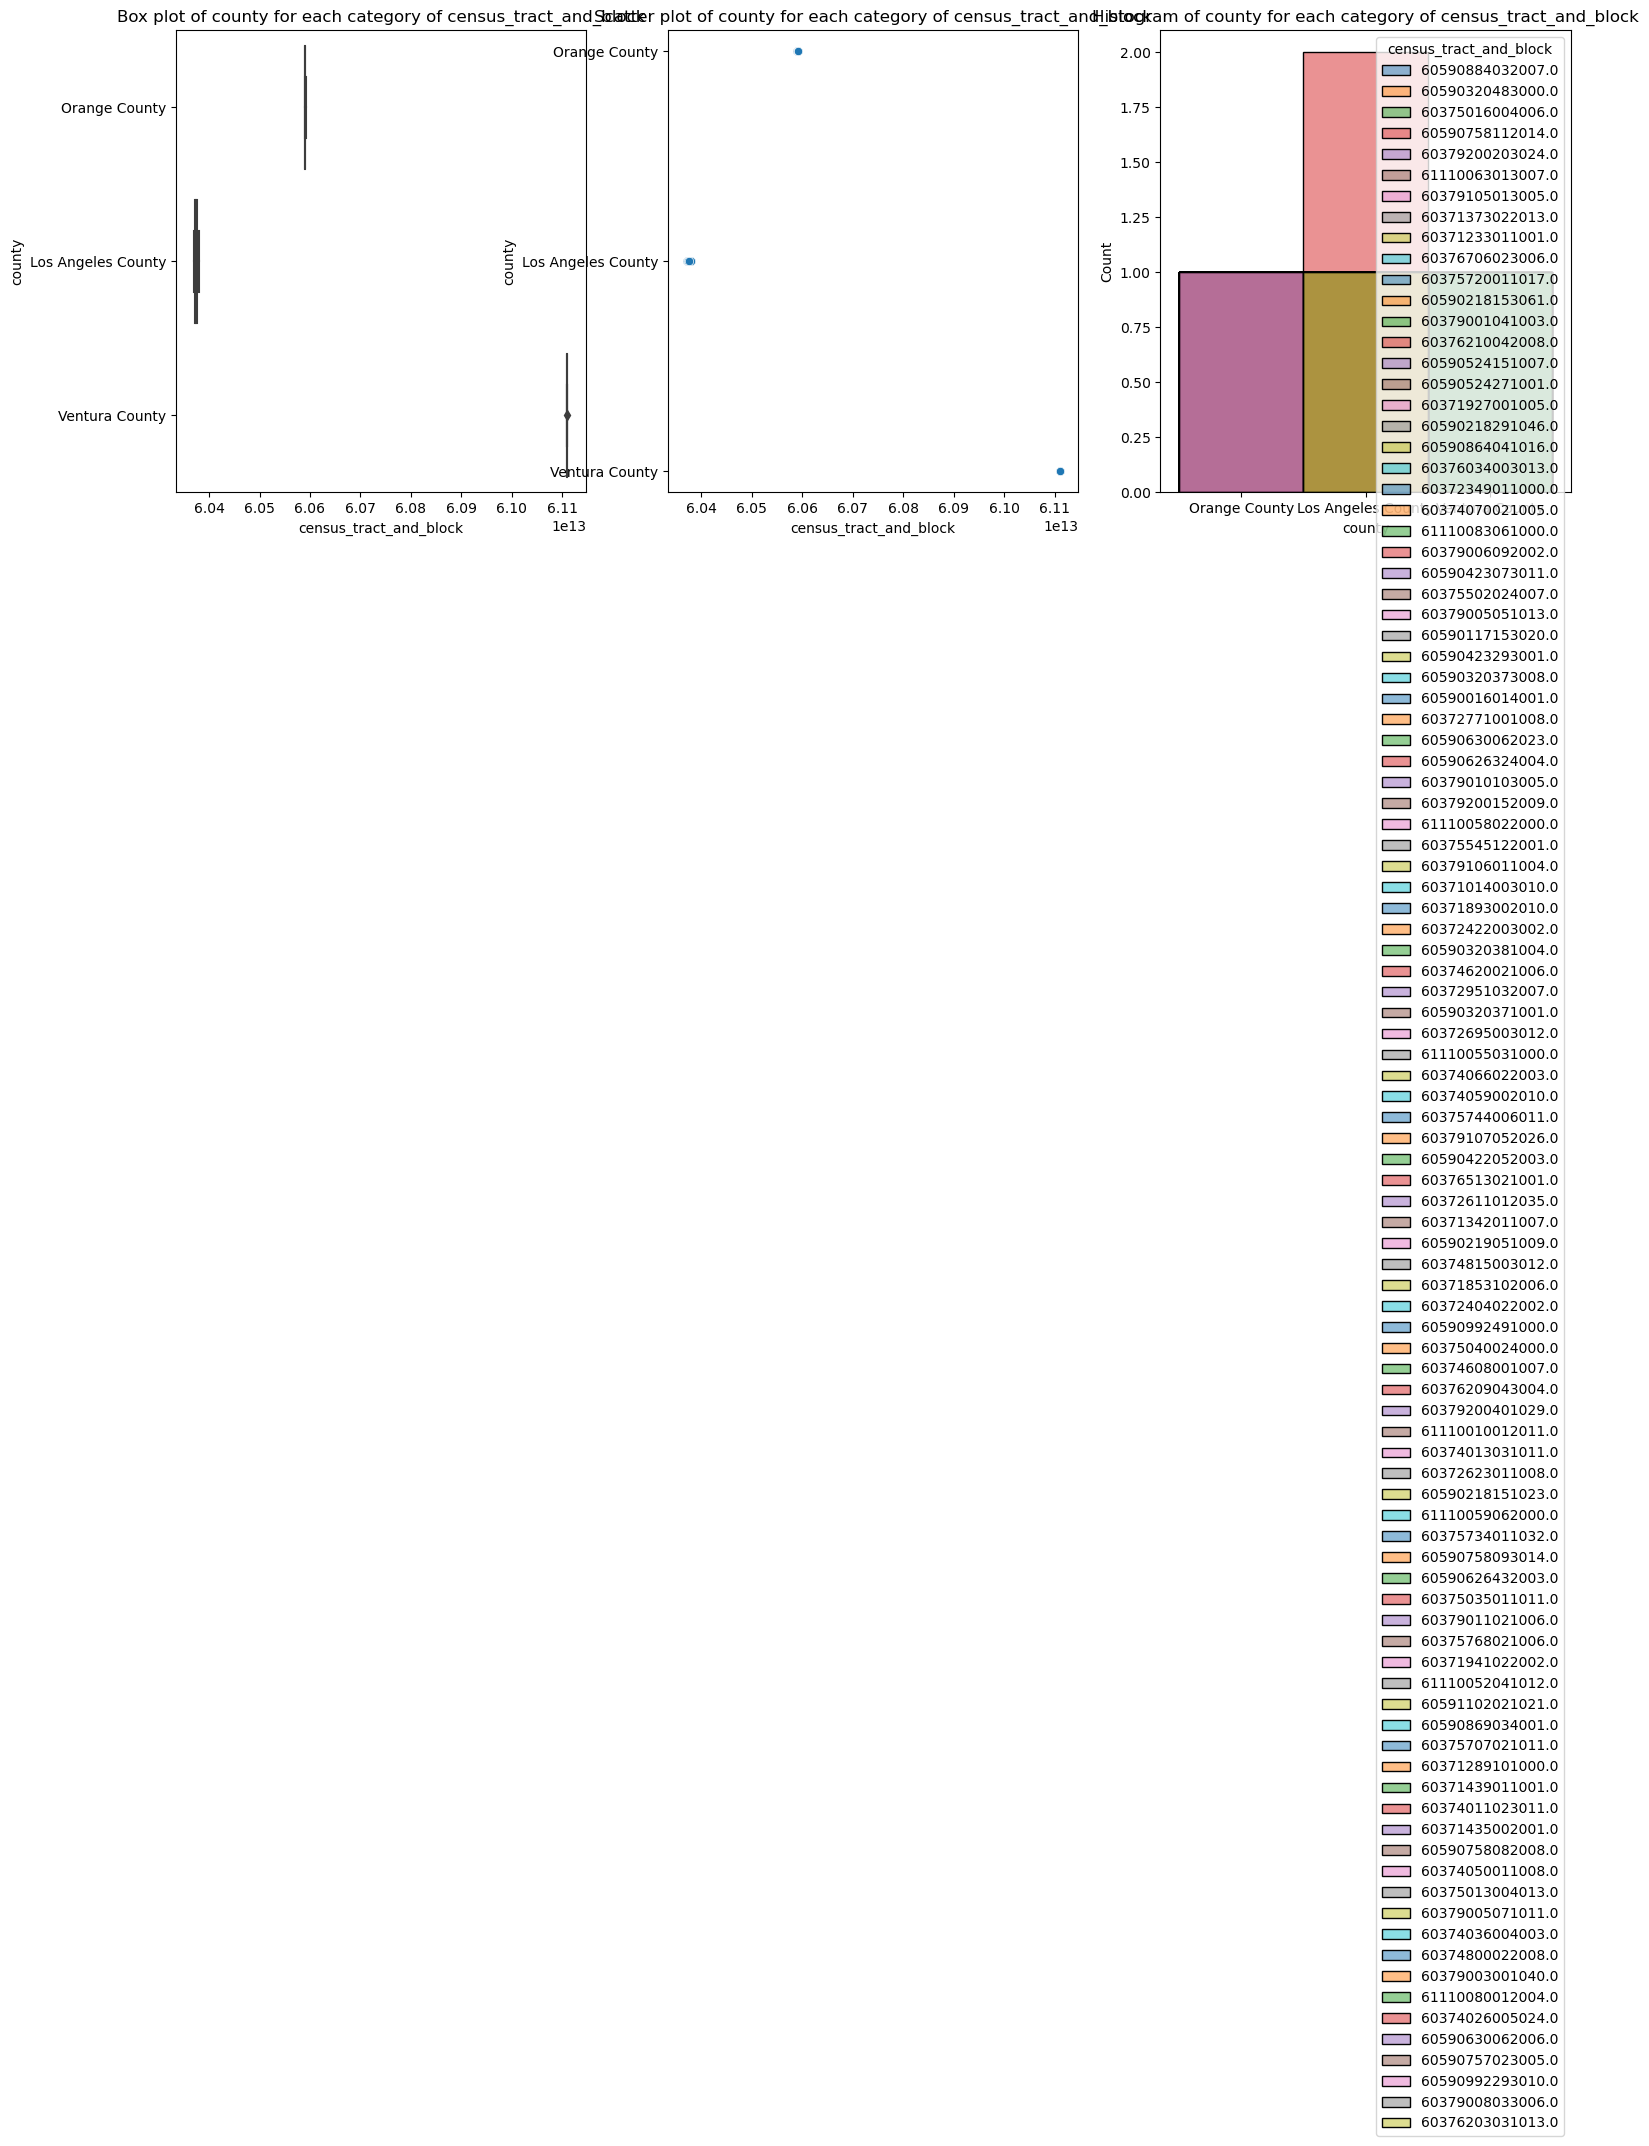

In [65]:
plot_categorical_and_continuous_vars(train, 'county', 'census_tract_and_block', n=None)

In [54]:
# def dist_of_nums():
    
#     for col in train.columns[train.dtypes != 'object']:

#         plt.figure()
#         sns.histplot(data = train, x = col)
#         plt.title(f'Distribution of {col}')
#         plt.show()

In [55]:
# def dist_of_objects():
    
#     for col in train.columns[train.dtypes == 'object']:
    
#         plt.figure()
#         sns.countplot(data = train, x = col)
#         plt.title(f'Count of {col}')
#         plt.show()

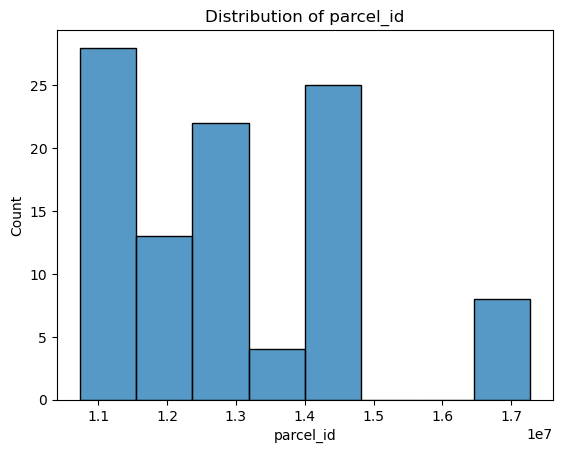

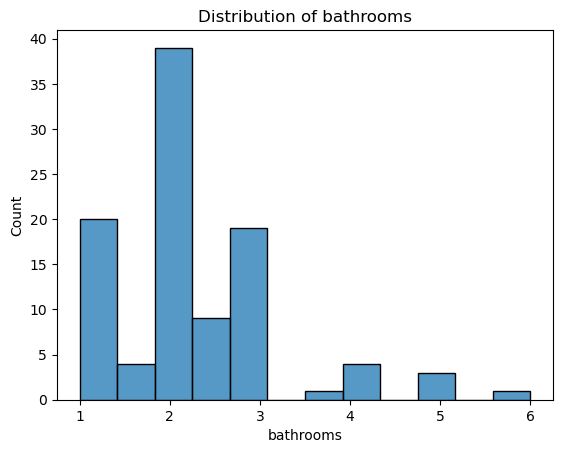

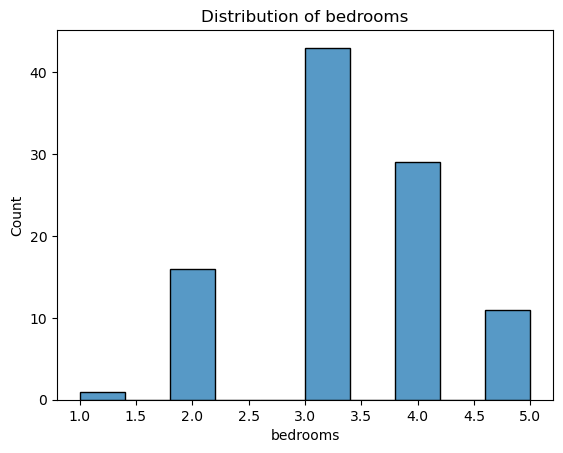

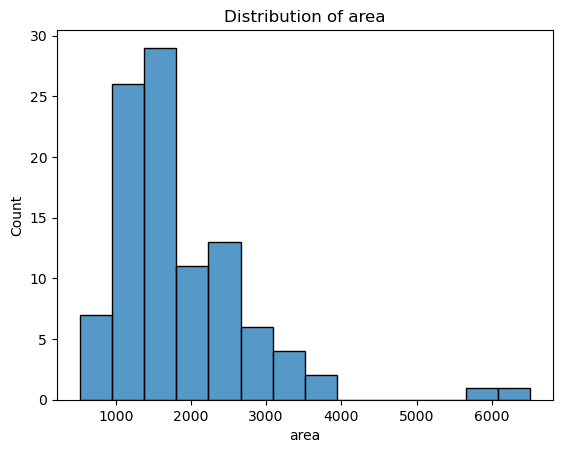

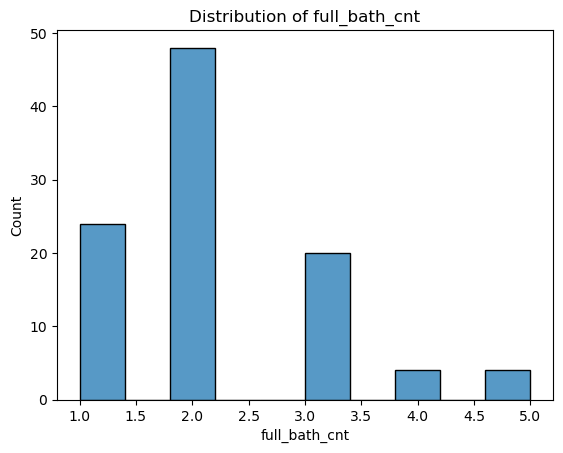

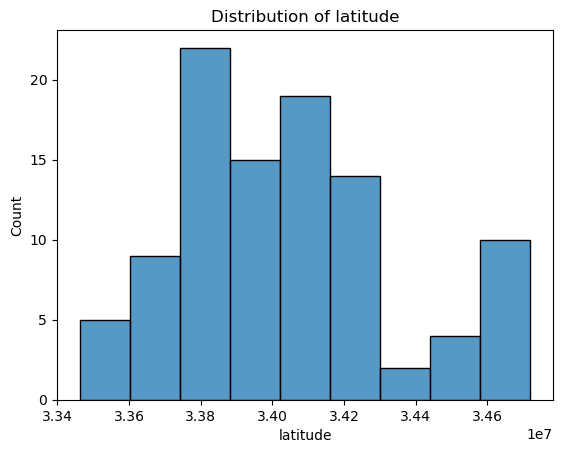

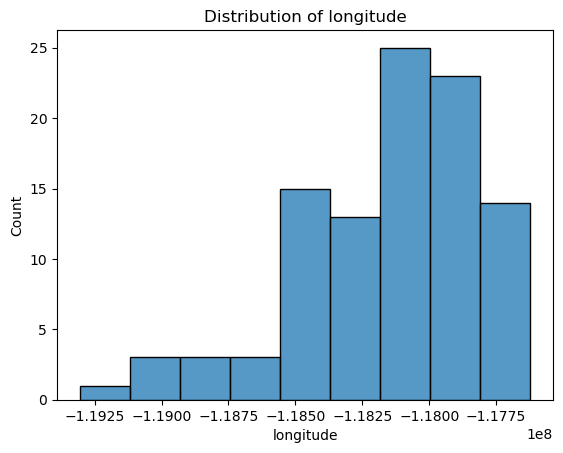

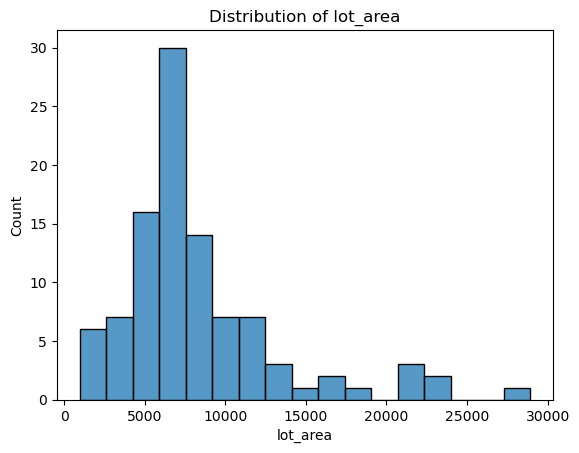

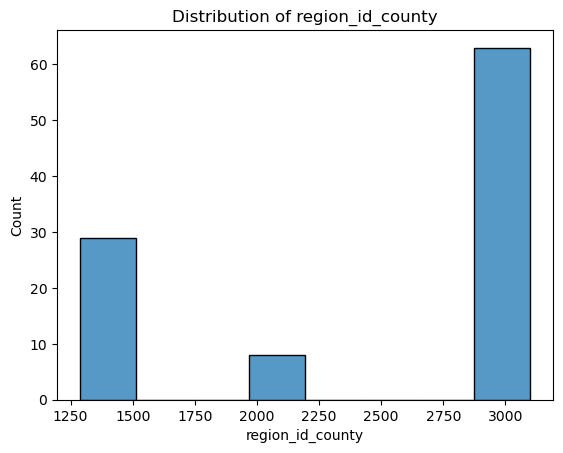

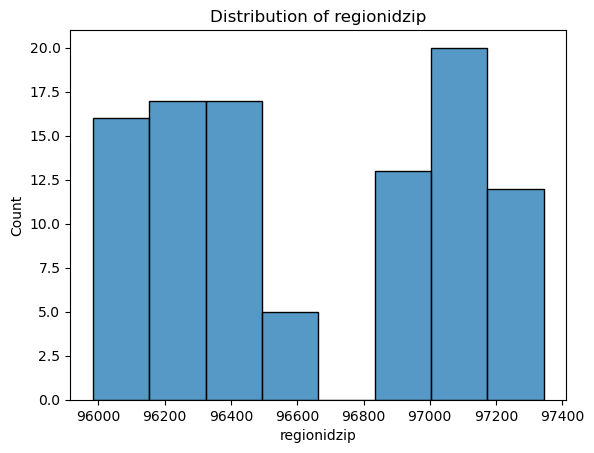

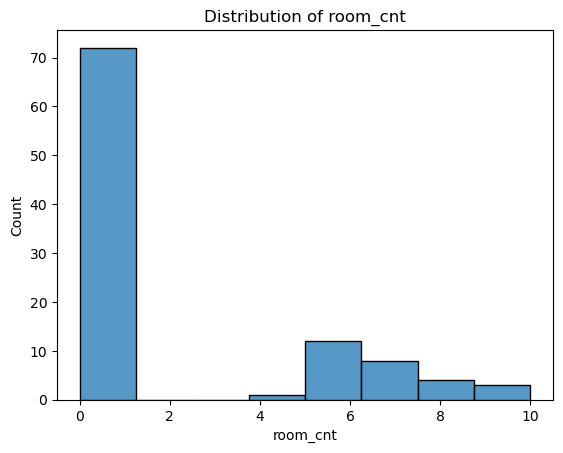

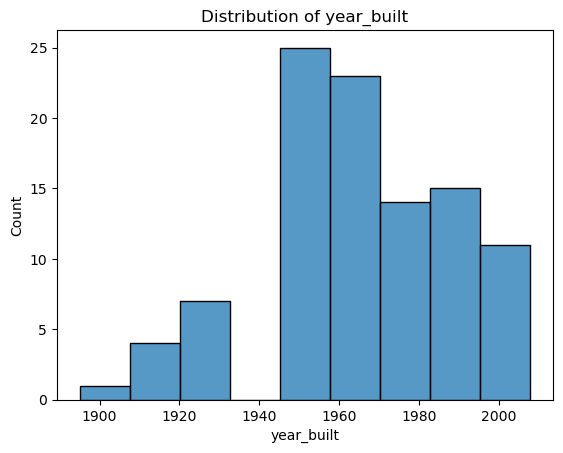

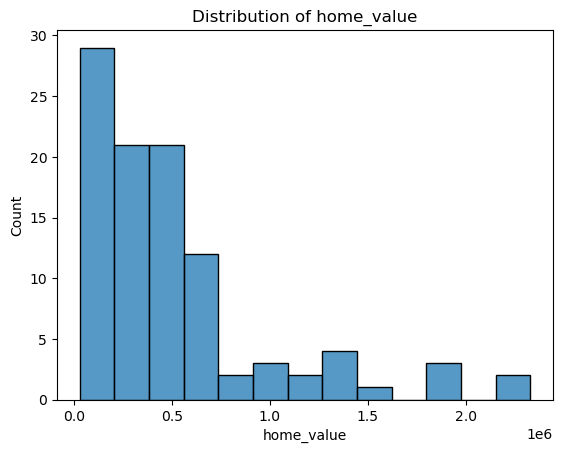

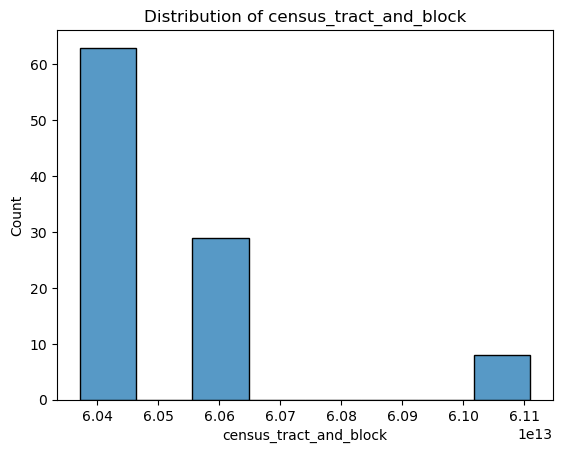

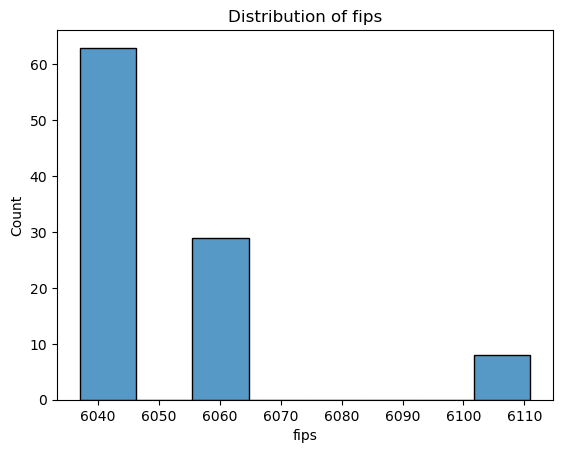

In [56]:
dist_of_nums(train)

In [57]:
train.dtypes == object

parcel_id                 False
bathrooms                 False
bedrooms                  False
area                      False
full_bath_cnt             False
latitude                  False
longitude                 False
lot_area                  False
region_id_county          False
regionidzip               False
room_cnt                  False
year_built                False
home_value                False
census_tract_and_block    False
fips                      False
state                      True
county                     True
dtype: bool

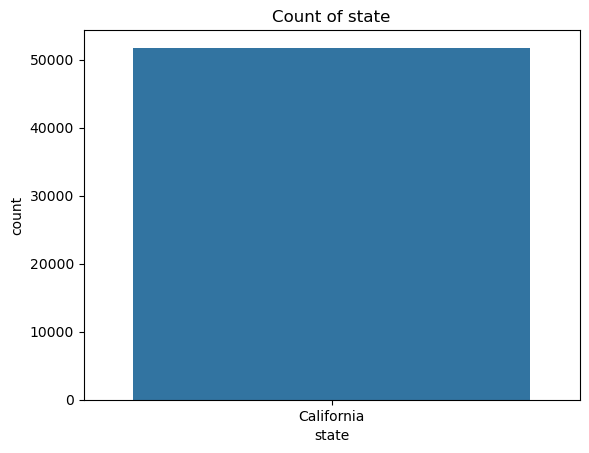

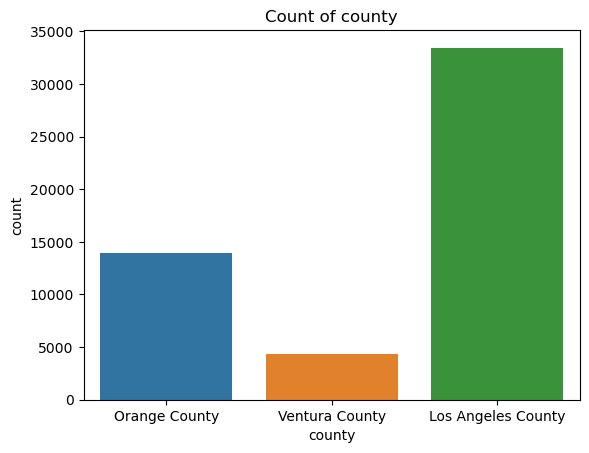

In [58]:
# dist_of_objects(df)

for col in df.columns[df.dtypes == 'object']:

    plt.figure()
    sns.countplot(data = df, x = col)
    plt.title(f'Count of {col}')
    plt.show()

## EXPLORATION DONE!

takeaway: 

- The datset consist of alot of LA county homes,
- All counties are in the state of california.
- There is a right skew to quite a few dsitributions between categorical and continuous data.
- home value is on the lower range of the scale when they are all compared.
- larger homes exists in ventura county as well as the number of room_cnt and lot_area versus the other counties.
- most properties are listed with 0 in la county, i'm not entirely sure why, may be an issue
- the data is proportionate with home detail features versus geolocation and outside markers for single residential properties.

## Going to ask and answer 4 questions

In [ ]:
Questions